# Scikit-Learn: Logistic Regression

In this section we will use the `linear_model` module from the `sklearn` library to predict if the individual will earn over 50K or not. We will be implementing a `Logistic Regression` model.

In [16]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

---

## Load Processed Datasets

Read the preprocessed train/test feature matrices and labels, plus the validation features. These CSVs were produced earlier by the preprocessing pipeline (one-hot + numeric scaling), and will be the consistent input for all models.

In [17]:
# Reload features
X_train = pd.read_csv("../data/processed/X_train.csv")
X_test  = pd.read_csv("../data/processed/X_test.csv")
X_val = pd.read_csv("../data/processed/X_val.csv")

# Reload targets (squeezed into Series)
y_train = pd.read_csv("../data/processed/y_train.csv").squeeze("columns")
y_test  = pd.read_csv("../data/processed/y_test.csv").squeeze("columns")

# Align one-hot columns (safety)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)
X_val  = X_val.reindex(columns=X_train.columns,  fill_value=0)

In [18]:
# To numpy
Xtr = X_train.to_numpy(dtype=np.float64, copy=False)
ytr_ppn = y_train.to_numpy(dtype=np.int64,  copy=False)   # Perceptron wants class labels
ytr_ada = y_train.to_numpy(dtype=np.float64, copy=False)  # Adaline learns on 0.0/1.0
Xte = X_test.to_numpy(dtype=np.float64,  copy=False)
yte = y_test.to_numpy(dtype=np.int64,    copy=False)
Xv  = X_val.to_numpy(dtype=np.float64,   copy=False)

---

## Confusion Matrix Plot Function

This function will help us plot our confusion matrix later on, so we can analyze our results. 

In [19]:
def plot_confusion_matrix(cm, y_true):
    """
    Plots the confusion matrix using a heatmap.

    Args:
        cm (np.ndarray): The confusion matrix.
        y_true (np.ndarray): The true labels for the test data.
    """
    # Create the plot using pure matplotlib
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Use imshow to create the heatmap
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the unique class names
           xticklabels=np.unique(y_true), yticklabels=np.unique(y_true),
           title='Confusion Matrix',
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()

---

## Initial Model (No Hyperparameter Tunning)

In [20]:
# Initialize the model with default parameters.
# For multi-class problems, LogisticRegression uses a one-vs-rest strategy by default.
# The 'solver' is set to 'lbfgs' as it's a good default for multi-class problems.
model = LogisticRegression(solver='lbfgs', random_state=42, max_iter=200)
model.fit(X_train, y_train.values.ravel())

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,200
,multi_class,'deprecated'


In [21]:
# Make predictions on the scaled test set.
y_pred = model.predict(X_test)

Now we will display the results of our initial model's prediction on the test dataset.


--- Confusion Matrix ---
[[5523  411]
 [ 785 1096]]

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.88      0.93      0.90      5934
           1       0.73      0.58      0.65      1881

    accuracy                           0.85      7815
   macro avg       0.80      0.76      0.77      7815
weighted avg       0.84      0.85      0.84      7815



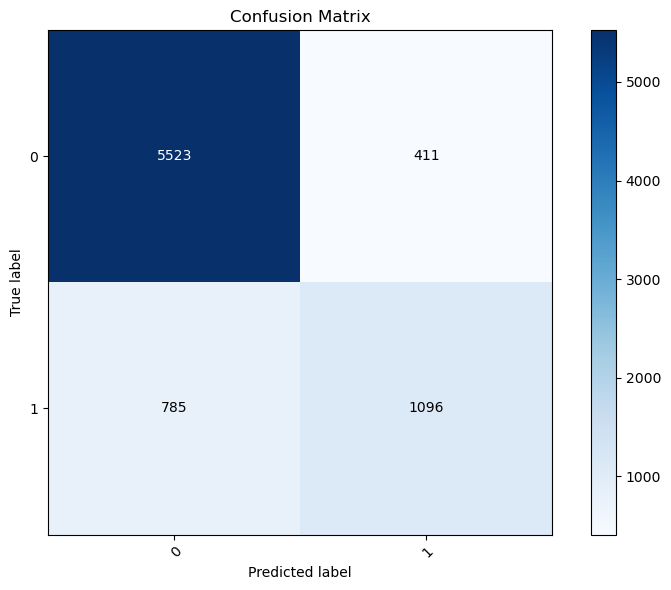

In [22]:
# Generate and display the confusion matrix and classification report
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred)
print(cm)

print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))

# Plot the predictions and the confusion matrix
plot_confusion_matrix(cm, y_test)

Accuracy sits at 85%, driven mostly by the model’s strong ability to identify people earning ≤ $50 K, where recall reaches 93%. The model struggles more with the > $50 K group, capturing only 58% of actual high earners and producing false positives in roughly one out of every four positive predictions (73% precision). Because the positive class is smaller and harder to detect, the macro averages lag the overall metrics, signaling that class imbalance remains an issue. If catching more high earners matters, consider adjusting the threshold, adding class weights, or enriching the features to boost recall while watching the precision trade-off.

---

## GridSearchCV for Hyperparamter Tunning

Now we will use GridSearchCV to find the best hyperparameters for the model. Cross-validation (CV) helps to get a more robust estimate of model performance and prevents overfitting to a single train-test split.

In [23]:
# Define the parameter grid to search over.
# np.logspace(-4,4,2-) tells GridSearchCV to test 20 values for C eenly spaced on logarithmic scale from 10^-4 to 10^4
param_grid = {
    'C': np.logspace(-4, 4, 20),  # Inverse of regularization strength
}

# Initialize GridSearchCV with a 5-fold cross-validation strategy.
grid_search = GridSearchCV(
    estimator=LogisticRegression(solver='lbfgs', random_state=42, max_iter=200),
    param_grid=param_grid,
    cv=5,                     # 5-fold cross-validation
    scoring='accuracy',       # Metric to optimize for
    n_jobs=-1,                # Use all available CPU cores
    verbose=1                 # Print progress
)

print("Starting hyperparameter search. This may take a moment...")
grid_search.fit(X_train, y_train.values.ravel())

Starting hyperparameter search. This may take a moment...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


,estimator,LogisticRegre...ndom_state=42)
,param_grid,{'C': array([1.0000...00000000e+04])}
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l2'


---

# Testing Logistic Regression Model with New Hyperparameters


--- Best Model Found by GridSearchCV ---
Best parameters: {'C': 0.615848211066026}
Best cross-validation accuracy: 0.8530

 Final evaluation of the best model on the test set...
Final accuracy on test set: 0.8476

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.93      0.90      5934
           1       0.73      0.58      0.65      1881

    accuracy                           0.85      7815
   macro avg       0.80      0.76      0.78      7815
weighted avg       0.84      0.85      0.84      7815


Confusion Matrix:
[[5527  407]
 [ 784 1097]]


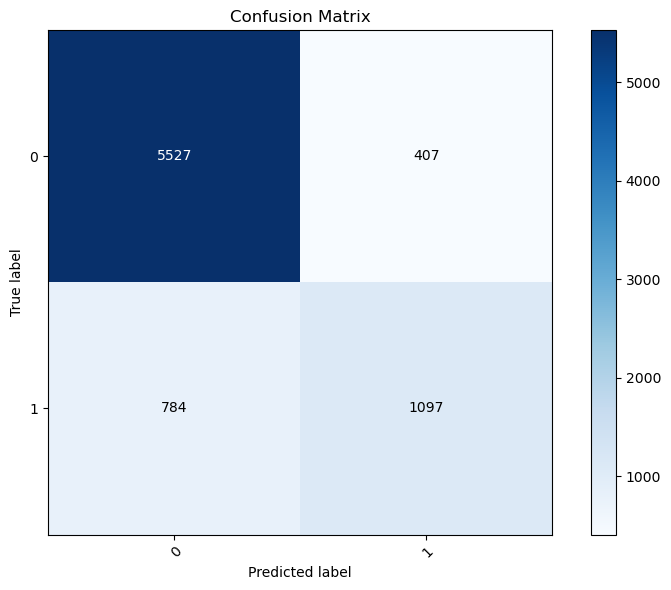

In [24]:
# Get the best estimator from the search.
best_model = grid_search.best_estimator_

print("\n--- Best Model Found by GridSearchCV ---")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

print("\n Final evaluation of the best model on the test set...")
# Predict using the best model found during the search.
final_y_pred = best_model.predict(X_test)
final_accuracy = accuracy_score(y_test, final_y_pred)

print(f"Final accuracy on test set: {final_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, final_y_pred))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, final_y_pred)
print(cm)

# Plot the predictions and the confusion matrix
plot_confusion_matrix(cm, y_test)

GridSearchCV settled on `C ≈ 0.62`, yielding 85.3% cross-validation accuracy, which stays tight with the 84.8% test accuracy—encouraging evidence that the model generalizes well. Compared to the earlier run, performance is essentially unchanged: accuracy holds at 85%, class `0` still posts 93% recall, and class `1` remains tougher with 58% recall and 73% precision. The confusion matrix barely shifts (four more true negatives, one extra true positive), so the tuning mainly confirms the model’s stability rather than moving the metrics. This consistency between validation and test scores suggests the current feature set and regularization strike a solid balance despite the lingering high-earner recall gap.

----

## Visualizing Decision Boundaries on Final Model

In [25]:
def plot_scatter_with_decision_regions(
    X_train2d, y_train,
    X_test2d=None, y_test=None,
    feature_names=("feature 1", "feature 2"),
    title="Train vs Test with Decision Regions",
    # classifier controls
    svc_params=None, classifier=None, fit_classifier=True,
    # look & feel
    train_alpha=0.25, test_alpha=0.45, region_alpha=0.18,
    quantile_bounds=True, q_lo=0.1, q_hi=99.9, pad=0.08,
    figsize=(8, 6),
    class_labels={0:"<=50K", 1:">50K"},   # <- color legend text
    savepath=None
):
    # --- accept DataFrame/Series or ndarray ---
    Xtr = X_train2d.to_numpy() if isinstance(X_train2d, pd.DataFrame) else np.asarray(X_train2d)
    ytr = np.asarray(y_train).reshape(-1)
    Xte = None; yte = None
    if X_test2d is not None: Xte = X_test2d.to_numpy() if isinstance(X_test2d, pd.DataFrame) else np.asarray(X_test2d)
    if y_test   is not None: yte = np.asarray(y_test).reshape(-1)

    # --- build/fit classifier (defaults to RBF SVC if none provided) ---
    if classifier is None:
        classifier = SVC(**(svc_params or dict(kernel='rbf', C=1.0, gamma='scale')))
    if fit_classifier:
        mask = np.isfinite(Xtr).all(axis=1) & np.isfinite(ytr)
        X_fit, y_fit = Xtr[mask], ytr[mask]
        if np.unique(y_fit).size < 2:
            raise ValueError("Need >=2 classes to draw decision regions.")
        classifier.fit(X_fit, y_fit)

    # --- grid bounds (robust) ---
    xs = [Xtr[:,0]]; ys = [Xtr[:,1]]
    if Xte is not None: xs.append(Xte[:,0]); ys.append(Xte[:,1])
    x_all, y_all = np.concatenate(xs), np.concatenate(ys)
    if quantile_bounds:
        x_min, x_max = np.nanpercentile(x_all, [q_lo, q_hi])
        y_min, y_max = np.nanpercentile(y_all, [q_lo, q_hi])
    else:
        x_min, x_max = np.nanmin(x_all), np.nanmax(x_all)
        y_min, y_max = np.nanmin(y_all), np.nanmax(y_all)
    xr, yr = (x_max-x_min), (y_max-y_min)
    x_min -= pad*xr; x_max += pad*xr; y_min -= pad*yr; y_max += pad*yr

    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                         np.linspace(y_min, y_max, 500))
    Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # --- plot ---
    fig, ax = plt.subplots(figsize=figsize)
    ax.contourf(xx, yy, Z, alpha=region_alpha, cmap=plt.cm.coolwarm)

    sc_train = ax.scatter(Xtr[:,0], Xtr[:,1], c=ytr, cmap="coolwarm",
                          edgecolor="none", alpha=train_alpha, label="train", s=30)
    if Xte is not None and yte is not None:
        sc_test  = ax.scatter(Xte[:,0], Xte[:,1], c=yte, cmap="coolwarm",
                              marker="s", edgecolor="none", alpha=test_alpha, label="test", s=35)

    ax.set_xlabel(feature_names[0]); ax.set_ylabel(feature_names[1])
    ax.set_title(title)

    # ---- legends ----
    # 1) Class color legend (inside axes, top-right)
    cmap = plt.cm.coolwarm
    uniq = np.unique(np.concatenate([ytr, yte]) if yte is not None else ytr)
    uniq = np.sort(uniq)
    # map first class to blue-ish, second to red-ish
    color_map = {uniq[0]: cmap(0.05), uniq[-1]: cmap(0.95)} if len(uniq) >= 2 else {uniq[0]: cmap(0.5)}
    class_handles = [Patch(facecolor=color_map[c], edgecolor='none',
                           label=class_labels.get(int(c), str(c))) for c in uniq]
    leg_classes = ax.legend(handles=class_handles, title="Class color", loc="upper right", frameon=True)
    ax.add_artist(leg_classes)

    # 2) Dataset legend (train/test) OUTSIDE, centered below
    dataset_handles = [
        Line2D([0],[0], marker='o', linestyle='', label='train',
               markerfacecolor='gray', markeredgecolor='none', markersize=7, alpha=train_alpha),
        Line2D([0],[0], marker='s', linestyle='', label='test',
               markerfacecolor='gray', markeredgecolor='none', markersize=7, alpha=test_alpha),
    ]
    fig.legend(handles=dataset_handles, loc='lower center', ncol=2, frameon=False, bbox_to_anchor=(0.5, 0.01))

    # layout + optional save
    fig.tight_layout(rect=[0.02, 0.06, 1.00, 0.95])  # bottom room for legend, top for title
    if savepath:
        os.makedirs(os.path.dirname(savepath), exist_ok=True)
        fig.savefig(savepath, dpi=220, bbox_inches='tight', facecolor='white')
    plt.show()

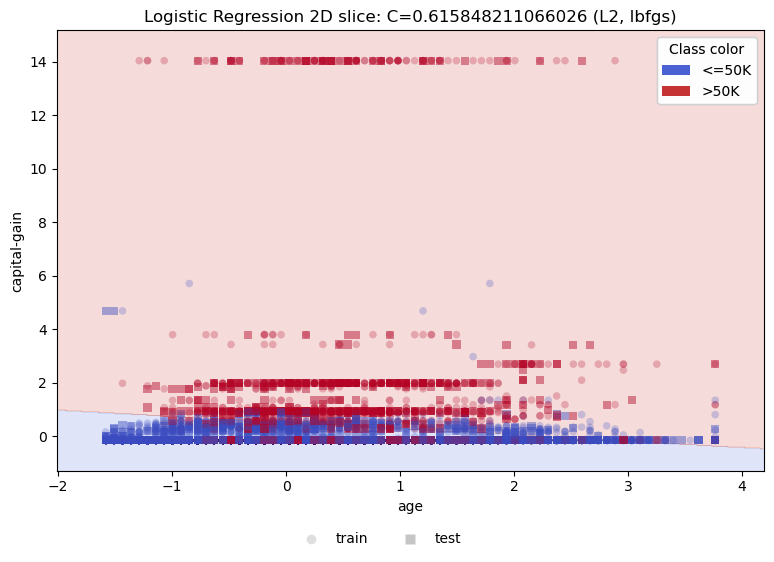

In [28]:
# Two features (same used in SVM)
top2 = ["age", "capital-gain"]
Xtr2 = X_train.loc[:, top2]
Xte2 = X_test.loc[:, top2]

# Model
try:
    best_C = grid_search.best_estimator_.C
except AttributeError:
    best_C = grid_search.best_params_.get("logisticregression__C", 1.0)

# Fresh LR for the 2-D slice; fit inside the plotting helper
logreg2d = LogisticRegression(
    C=best_C, penalty="l2", solver="lbfgs", max_iter=2000, random_state=42
)

# File name for visual
# --- file name for the plot ---
out = f"../outputs/graphs/logreg_regions_{top2[0]}_vs_{top2[1]}_C{best_model.C}.png"

plot_scatter_with_decision_regions(
    Xtr2, y_train,
    Xte2, y_test,
    feature_names=tuple(top2),
    title=f"Logistic Regression 2D slice: C={best_C} (L2, lbfgs)",
    classifier=logreg2d,        
    fit_classifier=True,        
    svc_params=None,            
    class_labels={0:"<=50K", 1:">50K"},
    savepath=out
)

---

## Predicting Outputs for `project_validation_inputs`

Generating the required prediction files (0/1, one per line, no header) for `project_validation_inputs.csv`.

In [ ]:
# Save Logistic Regression predictions (0/1)
pd.Series(best_model.predict(Xv)).to_csv(
    "../outputs/Group_18_LogisticRegression_PredictedOutputs.csv", 
    index=False, header=False
)